In [2]:
## config, edit
# https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.config.html
from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset
CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### eq_Taux_sea_cycle: zonal structure of the amplitude of the mean seasonal cycle of Taux in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of of equatorial Pacific (150°E-90°W) amplitude (standard deviation) of the mean annual cycle (zonal 5°S-5°N average) zonal wind stress (Taux) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

https://github.com/CLIVAR-PRP/ENSO_metrics/wiki/SeasonalTauxLonRmse#eq_taux_sea_cycle-zonal-structure-of-the-amplitude-of-the-mean-seasonal-cycle-of-taux-in-the-equatorial-pacific

## Dataset

In [3]:
# 20CRv2 1871-2012, ERA-Interim 1979-2018, NCEP2 1979-2018 # TropFlux 1979-2018 (main)

obs = Dataset(dataset= 'ERA-Interim', project= 'OBS6', type= 'reanaly', version='1', 
                    timerange='1979/2018', tier='3', mip='Amon', short_name='tauu')
# list(obs.from_files())
len(obs.files)

40

In [4]:

## model
var = Dataset(
    short_name='tauu',
    mip='Amon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    timerange='*',
    # derive='true'
)
list(var.from_files())[0].files
var.files


[LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tauu/gn/v20191108/tauu_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')]

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):
- detrending (if applicable)
- mean annual cycle computation
- standard deviation computation
- regridding (if applicable)
- meridional average
- RMSE computation

In [6]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # for zonal 5°S-5°N average meridional
                regrid, #esmf bilinear
                mask_landsea,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics ) # month mean, standard deviation

import numpy as np

In [33]:
 #{var['dataset']: var.load(), obs['dataset'] :obs.load()}

## base
def preproc_base(cube):
    cube = detrend(cube, dimension='time', method='linear')
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, 150, 270, -5,5)
    # cube = extract_region(cube, 130, 290, -15,15) #90-270, -5,5 for visual
    cube = climate_statistics(cube,'mean', period='monthly')
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube.convert_units('1e-3 N/m2')
    return cube
# print(cube.data.max(),cube.data.min(), cube.units)

# level 1 plot - obs and model? with collapsed
def preproc_3_1(cube):
    # cube = extract_region(cube, 150, 270, -5,5)
    cube = meridional_statistics(cube, 'mean')
    return cube

# level 3 hovmoller diagram - meridional, without collapsed
# cube_3 = extract_region(cube, 150, 270, -5,5)
# cube_3 = meridional_statistics(cube_3, 'mean')

# level 2 map std dev value
# cube = cube.collapsed('month_number', iris.analysis.STD_DEV)

print(cube.data.max(),cube.data.min(),cube.units)
# cube.summary()

# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

92.12962 1.0227326 1e-3 N/m2


In [ ]:
datasets = [var, obs]
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

#plot 1
process = {}
for ds in datasets:
    cube_process = preproc_base(ds.load())
    cube_process = cube_process.collapsed('month_number', iris.analysis.STD_DEV)
    process[ds['dataset']] = preproc_3_1(cube_process)

error = rmse(process['ERA-Interim'], process['ACCESS-CM2'])  #'numpy.float32' object is not callable
print(error)

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tauu/gn/v20191108/tauu_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'month_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'month_number'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot c

In [ ]:
#plot 1
qplt.plot(process['ACCESS-CM2'], label='Model', linewidth=2)
qplt.plot(process['ERA-Interim'], color='black', label='Observation', linewidth=2)

plt.text(0.5, 0.95, f'RMSE: {error:.2f} 1e-3 N/m2', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
ax = plt.gca()
# ax.set_ylim([5,17])

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


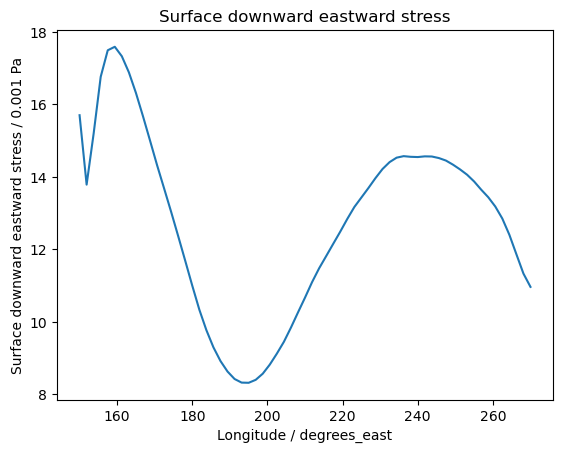

In [33]:

cube = extract_region(cube, 150, 270, -5,5)

cube = meridional_statistics(cube, 'mean')
qplt.plot(cube)

1e-3 N/m2


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'projection'
  result = super().contourf(*args, **kwargs)


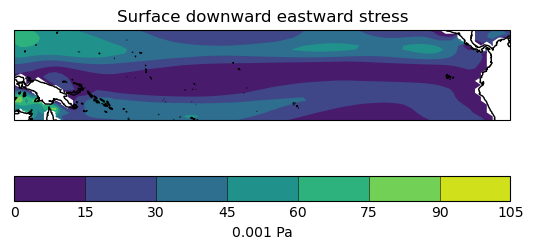

In [31]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.quickplot as qplt

## level 2 diagram
proj = ccrs.PlateCarree(central_longitude=210.0)
plt.subplot(projection=proj)
cube = mask_landsea(cube,'land')
print(cube.units)
qplt.contourf(cube, projection=proj)

plt.gca().coastlines()
# ticks longitude, lat, arrow legend

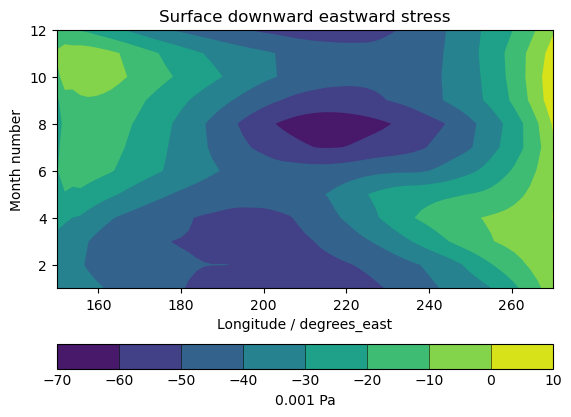

In [32]:
## level 3 diagram
# obs
qplt.contourf(cube_3)